Data Pre-processing¶

This notebook lists the steps of pre-processing the loan data from Lending Club (https://www.kaggle.com/wordsforthewise/lending-club/metadata) before applying it for training.

Import the packages required for the Data pre-processing:

In [2]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_profiling import ProfileReport

from matplotlib import cm 

In [3]:
# Data source: https://www.kaggle.com/wordsforthewise/lending-club/metadata
# loads lendingclub csv file
loan_data = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory = False)

In [4]:
# displays the dimension of dataframe
loan_data.shape
df = loan_data.copy()
df.shape

(2260701, 151)

In [5]:
# drops duplicate rows
df.drop_duplicates(inplace = True)
df.shape

(2260701, 151)

In [6]:
# The model is to predict the loan defaults from the loans with at least 24 months long, so 2018 data are removed.
mask = df['issue_d'].str[-4:] != '2018'
df = df[mask]
df.shape

(1765459, 151)

In [14]:
# Extracts the year from issue_d 
df['issue_y'] = df['issue_d'].str[-4:]

# Displays the distribution of number of observations by year
n_obs_by_year = df['issue_y'].value_counts()
pct_obs_by_year = round(df['issue_y'].value_counts()/df['issue_y'].value_counts().sum()*100,2)
df_year = pd.concat([n_obs_by_year, pct_obs_by_year], axis =1)
df_year.columns = ['n_obs', 'pct_obs']
df_year

,n_obs,pct_obs
2017,443579,25.13
2016,434407,24.61
2015,421095,23.85
2014,235629,13.35
2013,134814,7.64
2012,53367,3.02
2011,21721,1.23
2010,12537,0.71
2009,5281,0.30
2008,2393,0.14


In [15]:
# Calculated the number of observations for each unique value of loan_status by the total number of observations.
df['loan_status'].value_counts()

# Displays the distribution of each unique value in loan status
n_obs = df['loan_status'].value_counts()
pct_obs = round(df['loan_status'].value_counts()/df['loan_status'].value_counts().sum()*100,2)
loan_status_dist = pd.concat([n_obs, pct_obs], axis =1)
loan_status_dist.columns = ['n_obs', 'pct_obs']
loan_status_dist

,n_obs,pct_obs
Fully Paid,1029307,58.30
Current,451136,25.55
Charged Off,259692,14.71
Late (31-120 days),14246,0.81
In Grace Period,5517,0.31
Late (16-30 days),2746,0.16
Does not meet the credit policy. Status:Fully Paid,1988,0.11
Does not meet the credit policy. Status:Charged Off,761,0.04
Default,33,0.00


In [16]:
# Checks the year distribution of observations in the value of 'Does not meet the credit policy...' for the loan status column

notmeeetcredit = ['Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid']
mask =df['loan_status'].isin(notmeeetcredit)

df_does_not_meet = df[mask]
df_does_not_meet.groupby('issue_y')['id'].count()

issue_y
2007     352
2008     831
2009     565
2010    1001
Name: id, dtype: int64

In [17]:
# Removes observations with status 'Does not meet the credit policy. Status:Charged Off' and 'Does not meet the credit policy. Status:Fully Paid'
# since they only occured before 2010

mask = df['loan_status'].isin(notmeeetcredit)

# Creates new dataframe df1
df1=df[~mask]
df1.shape

(1762710, 152)

Create outcome label of the loan default indicator: 'good_bad' from feature 'loan_status':

Based on the information from lendingclub.com (linked below), In Grace Period, Late (16-30 days), Late (31-120 days), Default and Charged Off are all late payment in different stages (In Grace Period is past due with 15 days, Default is late payment beyond 120 days and Charged off means fail to collect the late payments). However, more than 70% loans in In Grace Period were paid in next 9 months; and about 60% of the loans with status in Late (16-30 days) and 80% of the loans with status in Late (31-120 days) will be charged off in the next 9 months.

So, we decided that Current, In Grace Period and Fully Paid are classified as non default loan, which means investors finally earned returns from those loans. Late (31-120 days), Late (16-30 days), Default and Charged Off are classified as default loans, which indicates investors incurred losses from those loans.

2749 records with statuses: Does not meet the credit policy. Status:Fully Paid and Does not meet the credit policy. Status:Charged Off only occurred from 2007 to 2010, which indicates they resulted from early policy and those situation are no longer existing in current loans. We made the decision to remove those observations from final analysis.

https://help.lendingclub.com/hc/en-us/articles/216109367-What-do-the-different-Note-statuses-mean- https://www.lendingclub.com/info/demand-and-credit-profile.action

In [19]:
# distribution of each unique value of loan_status
n_obs = df1['loan_status'].value_counts()
pct_obs = round(df1['loan_status'].value_counts()/df1['loan_status'].value_counts().sum()*100,2)
loan_status_dist = pd.concat([n_obs, pct_obs], axis =1)
loan_status_dist.columns = ['n_obs', 'pct_obs']
loan_status_dist

,n_obs,pct_obs
Fully Paid,1029307,58.39
Current,451136,25.59
Charged Off,259692,14.73
Late (31-120 days),14246,0.81
In Grace Period,5517,0.31
Late (16-30 days),2746,0.16
Default,33,0.00


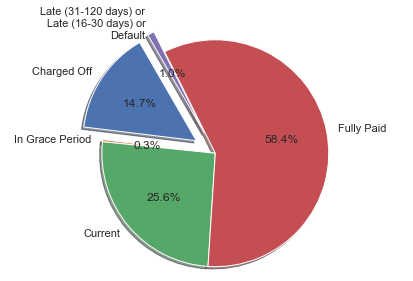

In [20]:
# Pie chart of loan_status
labels = [ 'Charged Off', 'In Grace Period', 'Current' , 'Fully Paid', 'Late (31-120 days) or\nLate (16-30 days) or\nDefault',]
sizes = [259692, 5517, 451136, 1029307 ,17025,]
explode = [0.2, 0, 0, 0, 0.2]

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=120)

plt.axis('equal')
plt.tight_layout()
plt.savefig('./figure1.png')

In [21]:
# Creates new column 'good_bad' as outcome label.
pd.options.mode.chained_assignment = None 

bad = ['Charged Off', 'Default','Late (31-120 days)','Late (16-30 days)' ]
df1['good_bad'] = np.where(df1['loan_status'].isin(bad), 1, 0)

# Displays the percentage of good and bad
df1['good_bad'].value_counts()/df1['good_bad'].value_counts().sum()

0    0.843016
1    0.156984
Name: good_bad, dtype: float64

In [22]:
# Displays bad_rates broken down by year

def bad_rate_by_cat(df, groupvar, dependcar):
    bad = df.groupby(groupvar)[dependcar].sum()
    count = df.groupby(groupvar)[dependcar].count()
    rate = df.groupby(groupvar)[dependcar].sum()/df.groupby(groupvar)[dependcar].count()
    bad_rate_by_cat = pd.concat((bad, count,rate), axis =1)
    bad_rate_by_cat.columns =  ['bad', 'total_count', 'bad_rate'] 
    
    return bad_rate_by_cat

bad_rate_by_cat(df1, 'issue_y', 'good_bad')

,bad,total_count,bad_rate
issue_y,,,
2007,45,251,0.179283
2008,247,1562,0.158131
2009,594,4716,0.125954
2010,1487,11536,0.128901
2011,3297,21721,0.151789
2012,8644,53367,0.161973
2013,21027,134814,0.155970
2014,41569,235629,0.176417
2015,77442,421095,0.183906


In [32]:
# Displays the column-wise distribution of null values:

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Creates a function to return the column-wise distribution of null values for a dataframe:
def null_dist(df):
   null_val_n = df.isnull().sum()
   null_var_pct = (df.isnull().sum()/len(df1)).round(4)
   null_var_dist = pd.concat([null_val_n, null_var_pct], axis = 1)
   null_var_dist.columns = ['null_val_n', 'null_val_pct']
   mask =null_var_dist['null_val_n'] > 0
   null_var_summary = null_var_dist[mask].sort_values(by='null_val_pct', ascending = False)
   print(null_var_summary)

null_dist(df1)


                                            null_val_n  null_val_pct
member_id                                      1762710        1.0000
orig_projected_additional_accrued_interest     1754380        0.9953
hardship_type                                  1752161        0.9940
hardship_status                                1752161        0.9940
deferral_term                                  1752161        0.9940
hardship_amount                                1752161        0.9940
hardship_start_date                            1752161        0.9940
hardship_end_date                              1752161        0.9940
payment_plan_start_date                        1752161        0.9940
hardship_length                                1752161        0.9940
hardship_dpd                                   1752161        0.9940
hardship_loan_status                           1752161        0.9940
hardship_payoff_balance_amount                 1752161        0.9940
hardship_last_payment_amount      

In [27]:
# Creates a list of columns with more than 50% missing values
feature_del_lst = (null_var_pct[null_var_pct > 0.5]).index.to_list()
len(feature_del_lst)

45

In [33]:
# Removes columns with more than 50% missing values 
df1.drop(feature_del_lst, axis=1 , inplace = True)
df1.shape

(1762710, 108)

In [34]:
# The below columns were identified as features available after the borrowers' loans defaulted.
# Removes those columns as they are no use to predict the loan default.
 
remove_lst = [
 #'loan_status',
 'num_tl_120dpd_2m',
 'collection_recovery_fee',
 'last_pymnt_d',
 'collections_12_mths_ex_med',
 'delinq_amnt',
 'emp_title',
 'recoveries',
 'hardship_flag',
 'title',
 'chargeoff_within_12_mths',
 'num_tl_30dpd',
 'acc_now_delinq',
 'num_tl_90g_dpd_24m',
# 'issue_y',
 'debt_settlement_flag',
 'tot_coll_amt']

df1.drop(remove_lst, axis=1 , inplace = True)
df1.shape

(1762710, 93)

Noticed that there are 38 columns having same number of missing values of 33. Looks like those were summary rows that were present in original lendingclub csv files. Those rows were removed from the analysis.

In [37]:
# Rows with missing values in loan_amnt,funded_amnt, total_acc....
mask = df1['pub_rec'].isnull()
df_missing = df1[mask]
print(df_missing.shape)
df_missing.head()

(33, 93)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,application_type,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_y,good_bad
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
528961,Total amount funded in policy code 1: 1741781700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
528962,Total amount funded in policy code 2: 564202131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
651664,Total amount funded in policy code 1: 1791201400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [38]:
# Remove 33 rows with missing values in loan_amnt, funded_amnt,....
mask = df1['pub_rec'].isnull()
df1.shape
# Creates new dataframe df2
df2 = df1[~mask]
df2.shape

(1762677, 93)

In [39]:
# Removes columns with more than 800,000 missing values which are account for over 40% of entire data. 
null_var1 = df2.isnull().sum()
feature_del_lst1 = (null_var1[null_var1 > 800000]).index.to_list()
len(feature_del_lst1)

13

In [40]:
df2.drop(feature_del_lst1, axis=1 , inplace = True)
df2.shape

(1762677, 80)

In [48]:
# Creates missing_percent to indicate that the precentage of columns with missing values for each row
df2['col_missing_ratio']=round((1- (df2.apply(lambda x: x.count(), axis = 1)/df2.shape[1])), 2)

In [42]:
# Displays df2 column-wise distribution of null values 
null_dist(df2)

                            null_val_n  null_val_pct
mths_since_recent_inq           231381        0.1313
mo_sin_old_il_acct              117912        0.0669
emp_length                      104886        0.0595
pct_tl_nvr_dlq                   67680        0.0384
mo_sin_rcnt_tl                   67527        0.0383
tot_hi_cred_lim                  67527        0.0383
num_tl_op_past_12m               67527        0.0383
num_rev_tl_bal_gt_0              67527        0.0383
num_rev_accts                    67528        0.0383
num_op_rev_tl                    67527        0.0383
num_il_tl                        67527        0.0383
num_bc_tl                        67527        0.0383
num_actv_rev_tl                  67527        0.0383
num_actv_bc_tl                   67527        0.0383
num_accts_ever_120_pd            67527        0.0383
mo_sin_rcnt_rev_tl_op            67528        0.0383
avg_cur_bal                      67557        0.0383
total_rev_hi_lim                 67527        

In [43]:
# There are 14 columns having same number of missing values 67527. 
mask = df2['num_bc_tl'].isnull()
df2[mask].head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,application_type,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_y,good_bad,missing_percent
1611879,1077501,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,171.62,Dec-2018,749.0,745.0,1.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Cash,2011,0,0.38
1611880,1077430,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,119.66,Oct-2016,499.0,0.0,1.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Cash,2011,1,0.38
1611881,1077175,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,649.91,Jun-2017,739.0,735.0,1.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Cash,2011,0,0.38
1611882,1076863,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,357.48,Apr-2016,604.0,600.0,1.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Cash,2011,0,0.38
1611883,1075358,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,67.30,Apr-2018,684.0,680.0,1.0,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Cash,2011,0,0.38


In [49]:
# Extracts those 67527 rows and found about 70% of those rows having more than 38% columns with missing values
mask = df2['num_bc_tl'].isnull()
df_test = df2[mask]
row_n = df_test['col_missing_ratio'].value_counts()
row_pct = (df_test['col_missing_ratio'].value_counts()/df_test['col_missing_ratio'].value_counts().sum()*100).round(2)
missing_columns = pd.concat([row_n, row_pct], axis = 1)
missing_columns_order = missing_columns.reset_index().sort_values(by = ['index'], ascending = False)
missing_columns_order.columns =[ 'column_missing_ratio','num_of_rows', 'percentage_of_rows']
missing_columns_order

,column_missing_ratio,num_of_rows,percentage_of_rows
8,0.40,45,0.07
3,0.38,2050,3.04
0,0.37,45186,66.92
11,0.33,3,0.00
10,0.32,28,0.04
7,0.31,78,0.12
9,0.30,42,0.06
6,0.28,155,0.23
5,0.27,1519,2.25
2,0.26,6943,10.28


In [50]:
# Those 67527 rows are records from early years before 2013.
df_test['issue_y'].value_counts()

2012    27741
2011    21721
2010    11536
2009     4716
2008     1562
2007      251
Name: issue_y, dtype: int64

In [51]:
# Removes those 67527 rows since they are from early years (before 2013) and most of columns (38%) are missing.
mask = df2['num_bc_tl'].isnull()
mask.head()
# Creates df3
df3=df2[~mask]
df3.shape

(1695150, 81)

In [53]:
# Displays df3 column-wise distribution of null values 
null_dist(df3)

                       null_val_n  null_val_pct
mths_since_recent_inq      181439        0.1029
emp_length                 102859        0.0584
mo_sin_old_il_acct          50385        0.0286
bc_util                     18954        0.0108
percent_bc_gt_75            18482        0.0105
bc_open_to_buy              18046        0.0102
mths_since_recent_bc        16945        0.0096
revol_util                   1089        0.0006
dti                           579        0.0003
pct_tl_nvr_dlq                153        0.0001
last_credit_pull_d             63        0.0000
avg_cur_bal                    30        0.0000
zip_code                        1        0.0000
inq_last_6mths                  1        0.0000
mo_sin_old_rev_tl_op            1        0.0000
mo_sin_rcnt_rev_tl_op           1        0.0000
num_rev_accts                   1        0.0000


In [54]:
# There are only one missing value in column: 'inq_last_6mths', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts','zip_code', 'mo_sin_old_rev_tl_op'
# We decide removing those records.
# df4 was created.

mask = df3['inq_last_6mths'].isnull()|df3['num_rev_accts'].isnull()|df3['mo_sin_old_rev_tl_op'].isnull()|df3['zip_code'].isnull()|df3['mo_sin_rcnt_rev_tl_op'].isnull()
df4 = df3[~mask]
print(df4.shape)
print(df3.shape)

(1695146, 81)
(1695150, 81)


In [55]:
null_dist(df4)

                       null_val_n  null_val_pct
mths_since_recent_inq      181438        0.1029
emp_length                 102858        0.0584
mo_sin_old_il_acct          50385        0.0286
bc_util                     18953        0.0108
percent_bc_gt_75            18481        0.0105
bc_open_to_buy              18045        0.0102
mths_since_recent_bc        16944        0.0096
revol_util                   1088        0.0006
dti                           579        0.0003
pct_tl_nvr_dlq                153        0.0001
last_credit_pull_d             63        0.0000
avg_cur_bal                    30        0.0000


In [56]:
# Correlation coefficient between inq_last_6mths and mths_since_recent_inq
df4['inq_last_6mths'].corr(df4['mths_since_recent_inq'])

-0.5659505791936963

In [57]:
# Removes column 'mths_since_recent_inq' since more than 10% of rows are missing
# and mths_since_recent_inq is highly correlated with inq_last_6mths
df4.drop('mths_since_recent_inq', axis=1 , inplace = True)
df4.shape

(1695146, 80)

In [58]:
# Distribution of each unique values in emp_length
df4['emp_length'].value_counts(dropna = False)

10+ years    570724
2 years      151590
< 1 year     138944
3 years      133705
1 year       109705
5 years      102921
NaN          102858
4 years       99492
6 years       76310
8 years       73118
7 years       71341
9 years       64438
Name: emp_length, dtype: int64

In [59]:
# Creates column emp_length_int from emp_length:
# replace missing values with zero, '<1 year' with 0.5 and remove year for other values

df4['emp_length_int']=np.where(df4['emp_length'] =='< 1 year', '0.5 years', df4['emp_length'] )
df4['emp_length_int']=np.where(df4['emp_length'].isnull(), 'missing 0', df4['emp_length_int'] )
df4['emp_length_int']=pd.to_numeric(df4['emp_length_int'].apply(lambda x: re.findall('\d+\.\d+|\d+',x)[0]))
df4['emp_length_int'].value_counts()

10.0    570724
2.0     151590
0.5     138944
3.0     133705
1.0     109705
5.0     102921
0.0     102858
4.0      99492
6.0      76310
8.0      73118
7.0      71341
9.0      64438
Name: emp_length_int, dtype: int64

In [60]:
# Removes column emp_length
del df4['emp_length']

count    1695146.00
mean         126.65
std           51.83
min            0.00
25%          100.00
50%          130.00
75%          152.00
max          999.00
Name: mo_sin_old_il_acct, dtype: float64
count    1695146.00
mean         126.65
std           51.83
min            0.00
25%          100.00
50%          130.00
75%          152.00
max          999.00
Name: mo_sin_old_il_acct, dtype: float64


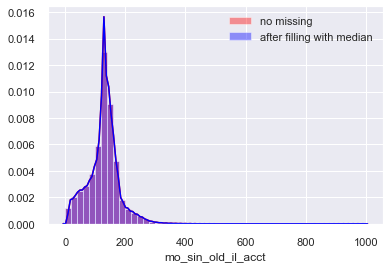

In [72]:
# Replaces missing values in 'mo_sin_old_il_acct' with median 
df4['mo_sin_old_il_acct'].fillna(df4['mo_sin_old_il_acct'].median(), inplace = True)
# Displays stats of mo_sin_old_il_acct
print(round(df4['mo_sin_old_il_acct'].describe(),2))
# Prepares the data to plot the distribution of o_sin_old_il_acct
mask = df4['mo_sin_old_il_acct'].isnull()
df_test = df4[~mask]
# The distribution of mo_sin_old_il_acct without missing values
%matplotlib inline
sns.distplot(df_test['mo_sin_old_il_acct'],color = 'red' ,label = 'no missing')
# The distribution of mo_sin_old_il_acct after filling missing values with median
print(round(df4['mo_sin_old_il_acct'].describe(),2))
sns.distplot(df4['mo_sin_old_il_acct'],color = 'blue', label = 'after filling with median')
plt.legend(loc = "upper right")

In [73]:
null_dist(df4)

                      null_val_n  null_val_pct
bc_util                    18953        0.0108
percent_bc_gt_75           18481        0.0105
bc_open_to_buy             18045        0.0102
mths_since_recent_bc       16944        0.0096
revol_util                  1088        0.0006
dti                          579        0.0003
pct_tl_nvr_dlq               153        0.0001
last_credit_pull_d            63        0.0000
avg_cur_bal                   30        0.0000


In [83]:
# Found that zero values in total_bc_limit result missing values in bc_util,percent_bc_gt_75 ,bc_open_to_buy and mths_since_recent_bc

mask = df4['total_bc_limit']== 0.0
df_test = df4[mask]
print('==Number of observations with total_bc_limit = 0')
print(df_test.shape[0])

var_list = ['bc_util','percent_bc_gt_75' ,'bc_open_to_buy', 'mths_since_recent_bc']
for var in var_list:
   print(f'==Distribution of {var} when total_bc_limit = 0')
   print(df_test[var].value_counts(dropna = False).head()) 

==Number of observations with total_bc_limit = 0
18481
==Distribution of bc_util when total_bc_limit = 0
NaN    18045
0.0      436
Name: bc_util, dtype: int64
==Distribution of percent_bc_gt_75 when total_bc_limit = 0
NaN    18481
Name: percent_bc_gt_75, dtype: int64
==Distribution of bc_open_to_buy when total_bc_limit = 0
NaN    18045
0.0      436
Name: bc_open_to_buy, dtype: int64
==Distribution of mths_since_recent_bc when total_bc_limit = 0
NaN      16942
101.0       24
88.0        19
94.0        19
116.0       18
Name: mths_since_recent_bc, dtype: int64


In [84]:
# Correlation coefficient between mths_since_recent_bc and mo_sin_rcnt_rev_tl_op
print('Correlation coefficient between mths_since_recent_bc and mo_sin_rcnt_rev_tl_op ')
print(df4['mths_since_recent_bc'].corr(df4['mo_sin_rcnt_rev_tl_op']))
# # Removes mths_since_recent_bc since it is highly correlated with mo_sin_rcnt_rev_tl_op
del df4['mths_since_recent_bc']
df4.shape

Correlation coefficient between mths_since_recent_bc and mo_sin_rcnt_rev_tl_op 
0.6122477233799898


(1695146, 79)

In [85]:
# Replaces missing values of bc_util with round( ((df4['total_bc_limit']-df4['bc_open_to_buy'])/df4['total_bc_limit'])*100, 2) if bc_open_to_buy is not missing
# Replaces additional missing values with zero as those rows with zero values for total_bc_limit

df4['bc_util_cal']= round( ((df4['total_bc_limit']-df4['bc_open_to_buy'])/df4['total_bc_limit'])*100, 2)
df4['bc_util'].fillna(df4['bc_util_cal'], inplace = True)
df4['bc_util'].isnull().sum()

df4['bc_util'].fillna(0, inplace=True)
df4['bc_util'].isnull().sum()
del df4['bc_util_cal']

In [86]:
# Replaces missing values of percent_bc_gt_75 and bc_open_to_buy with zero as those rows with total_bc_limit=0
df4['percent_bc_gt_75'].fillna(0, inplace=True)
df4['bc_open_to_buy'].fillna(0, inplace=True)

In [87]:
null_dist(df4)

                    null_val_n  null_val_pct
revol_util                1088        0.0006
dti                        579        0.0003
pct_tl_nvr_dlq             153        0.0001
last_credit_pull_d          63        0.0000
avg_cur_bal                 30        0.0000


In [89]:
# Creates revol_util_cal using revol_bal divided by total_rev_hi_lim
df4['revol_util_cal']= round( ((df4['revol_bal'])/df4['total_rev_hi_lim'])*100, 2)

# Confirms that revol_util is same as revol_util_cal.
# so we can use the value of revol_util_cal to replace the missing value in revol_util 
df4[['revol_bal', 'revol_util', 'total_rev_hi_lim','revol_util_cal' ]].head()

,revol_bal,revol_util,total_rev_hi_lim,revol_util_cal
0,2765.0,29.7,9300.0,29.73
1,21470.0,19.2,111800.0,19.20
2,7869.0,56.2,14000.0,56.21
3,7802.0,11.6,67300.0,11.59
4,21929.0,64.5,34000.0,64.50


In [90]:
mask = df4['revol_util'].isnull()
df_test = df4[mask]

print(df_test['revol_bal'].value_counts().head(5))
df_test[['revol_bal', 'revol_util', 'total_rev_hi_lim']].head(5)


0.0        872
41345.0      2
3842.0       1
50094.0      1
42540.0      1
Name: revol_bal, dtype: int64


,revol_bal,revol_util,total_rev_hi_lim
1537,0.0,NaN,0.0
3577,488.0,NaN,2600.0
5674,6424.0,NaN,8000.0
6781,0.0,NaN,0.0
8116,0.0,NaN,0.0


In [91]:
# Replaces missing values of revol_util with round( ((df4['revol_bal'])/df4['total_rev_hi_lim'])*100, 2) if total_rev_hi_lim is not zero
df4['revol_util_cal']= round( ((df4['revol_bal'])/df4['total_rev_hi_lim'])*100, 2)
df4['revol_util'].fillna(df4['revol_util_cal'], inplace = True)

In [92]:
# Replaces additional missing values of revol_util with zero as those rows with zero values for total_rev_hi_lim
df4['revol_util'].fillna(0, inplace = True)
df4['revol_util'].isnull().sum()
del df4['revol_util_cal']

In [93]:
null_dist(df4)

                    null_val_n  null_val_pct
dti                        579        0.0003
pct_tl_nvr_dlq             153        0.0001
last_credit_pull_d          63        0.0000
avg_cur_bal                 30        0.0000


In [94]:
# stats of dti
print(round(df4['dti'].describe(),2))

count    1694567.00
mean          18.76
std           11.96
min           -1.00
25%           12.16
50%           18.03
75%           24.59
max          999.00
Name: dti, dtype: float64


In [96]:
# Creates dataframe only including dti with missing values
mask = df4['dti'].isnull()
df_test = df4[mask]

# Creates column dti_cal using installment divided by annual_inc
# Found that annual_inc = 0 results most of missing values in dti
df4['dti_cal']=round(df4['installment']/( df4['annual_inc']/12)*100,2)
df4[['annual_inc','installment', 'dti', 'dti_cal','issue_y']].head(20)
df_test[['annual_inc','installment', 'dti','issue_y','dti_cal','good_bad']].head(3)

,annual_inc,installment,dti,issue_y,dti_cal,good_bad
18202,0.0,712.96,NaN,2015,inf,0
65620,0.0,123.94,NaN,2015,inf,1
529149,0.0,278.73,NaN,2017,inf,0


In [97]:
# Removes rows with annual_inc less than 100$ 
mask = df4['annual_inc'] < 100
df_test = df4[mask]
print(df_test.shape)
print(df_test['issue_y'].value_counts())
# Creates df5
print(df4.shape)
df5 = df4[~mask]
print(df5.shape)

(588, 80)
2017    523
2016     63
2015      2
Name: issue_y, dtype: int64
(1695146, 80)
(1694558, 80)


In [98]:
print(round(df5['dti'].describe(),2))

count    1694558.00
mean          18.76
std           11.74
min           -1.00
25%           12.16
50%           18.03
75%           24.59
max          999.00
Name: dti, dtype: float64


In [99]:
# Removes the dti with negative value
mask = df5['dti'] < 0
print(df5.shape)
df5 = df5[~mask]
print(df5.shape)

(1694558, 80)
(1694556, 80)


In [100]:
null_dist(df5)

                    null_val_n  null_val_pct
pct_tl_nvr_dlq             153        0.0001
last_credit_pull_d          63        0.0000
avg_cur_bal                 30        0.0000


In [101]:
mask = df4['pct_tl_nvr_dlq'].isnull()
df_test = df4[mask]
df_test.head(15)
df_test['issue_y'].value_counts()

2013    153
Name: issue_y, dtype: int64

In [102]:
# Remove rows with missing value in 'pct_tl_nvr_dlq'
mask = df5['pct_tl_nvr_dlq'].isnull()
print(df5.shape)
# Creates df6
df6 = df5[~mask]
print(df6.shape)

(1694556, 80)
(1694403, 80)


In [103]:
# Remove rows with missing value in 'last_credit_pull_d'
mask = df6['last_credit_pull_d'].isnull()
print(df6.shape)
# Creates df7
df7 = df6[~mask]
print(df7.shape)

(1694403, 80)
(1694341, 80)


In [104]:
mask = df7['avg_cur_bal'].isnull()
df_test = df7[mask]
df_test.head(15)
# tot_cur_bal = 0 when ave_cur_bal is missing
df_test['tot_cur_bal'].value_counts()

0.0    30
Name: tot_cur_bal, dtype: int64

In [105]:
# Replaces the missing values of avg_cur_bal with zero, as those rows are zero in tot_cur_bal
df7['avg_cur_bal'].fillna(0, inplace = True)

In [106]:
# Confirms that there is no missing value in df7
null_dist(df7)

Empty DataFrame
Columns: [null_val_n, null_val_pct]
Index: []


In [108]:
# To confirm that the bad rate is similar as original after clean up.
# bad rate of df1
print('==df1 bad rate==')
print(df1['good_bad'].value_counts()/df1['good_bad'].value_counts().sum())
# Checks the bad rate of df7
print('==df7 bad rate==')
print(df7['good_bad'].value_counts()/df7['good_bad'].value_counts().sum())

==df1 bad rate==
0    0.843016
1    0.156984
Name: good_bad, dtype: float64
==df7 bad rate==
0    0.842827
1    0.157173
Name: good_bad, dtype: float64
